# Variables affecting HRDetect score

**BRCA status**

In [1]:
rm(list=ls())
#setwd("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/")
setwd("~/Desktop/BRCA1_BRCA2_SVs_paper/")
sampleInfo<-read.table("Manuscript/Intermediate_data/SampleInformation.txt",sep="\t",header=T,stringsAsFactors=F)
rownames(sampleInfo)<-sampleInfo[,1]

sampleInfo[sampleInfo$BRCAstatus=="None" & sampleInfo$BRCA1_pro_meth==1,"BRCAstatus"]<-"BRCA1 promoter methylation"
sampleInfo[sampleInfo$BRCAstatus=="BRCA1 promoter methylation","BRCAstatus_compound"]<-"BRCA1 promoter methylation"

In [2]:
dim(sampleInfo[sampleInfo$HRDetect>0.7 & sampleInfo$BRCAstatus=="None",])
dim(sampleInfo[sampleInfo$HRDetect>0.7 ,])

[1] 25 29

[1] 106  29

In [3]:
hrd<-sampleInfo[sampleInfo$HRDetect>0.7,]
table(hrd$BRCAstatus)


                                     BRCA1 promoter methylation 
                                                              9 
Complex combination of SV intervals including 1+ LOF (CPX: LOF) 
                                                              1 
                         Complex combination of SVs without LOF 
                                                              2 
                                Deletion overlapping exon (LOF) 
                                                             15 
                          Duplication spanning gene (COPY_GAIN) 
                                                              2 
                                                   Germline SNV 
                                                             28 
                             Inversion spanning gene (INV_SPAN) 
                                                              8 
                                                           None 
                        

In [4]:
dim(hrd[hrd$BRCA1_pro_meth==1 & hrd$BRCAstatus!="Germline SNV" & hrd$BRCAstatus!="Somatic SNV",])
table(sampleInfo$BRCA1_pro_meth,sampleInfo$Cohort)

[1] 16 29

   
    AO DO SH
  0 68 39 81
  1 12  5  0

**BRCA status**

In [5]:
library(ggplot2)
library(RColorBrewer)
library(ggpubr)
library(exact2x2)

sampleInfo$Cohort<-substr(sampleInfo$Sample,1,2)
sampleInfo$HRDeficient<-ifelse(sampleInfo$HRDetect>0.7,1,0)

#dat<-sampleInfo
dat<-sampleInfo[sampleInfo$BRCA1_pro_meth!=1,]

Loading required package: magrittr
Loading required package: exactci
Loading required package: ssanv


In [6]:
#Define categories

dat$BRCAstatus<-as.factor(dat$BRCAstatus)
dat$BRCAstatus <- relevel(dat$BRCAstatus, ref = "None")

dat$BRCAstatus_grpsvs<-as.character(dat$BRCAstatus)
dat$BRCAstatus_grpsvs_av<-as.character(dat$BRCAstatus)


dat[(dat$BRCAstatus=="Germline SNV"|dat$BRCAstatus=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCAstatus_grpsvs_av"]<-"SNV only"

dat[(dat$BRCAstatus=="Germline SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCAstatus_grpsvs"]<-"Germline SNV only"

dat[(dat$BRCAstatus=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCAstatus_grpsvs"]<-"Somatic SNV only"


dat[dat$BRCAstatus=="Deletion overlapping exon (LOF)"  ,
    "BRCAstatus_grpsvs"]<-"Deletion"

dat[(dat$BRCAstatus!="Germline SNV" & dat$BRCAstatus!="Somatic SNV" &
     dat$BRCAstatus!="None"& dat$BRCAstatus!="BRCA1 promoter methylation" & dat$BRCAstatus!="Deletion overlapping exon (LOF)" &
     dat$BRCAstatus!="Complex combination of SV intervals including 1+ LOF (CPX: LOF)" ) ,
    "BRCAstatus_grpsvs_av"]<-"Non-deletion structural variant"

dat[dat$BRCA1status=="Inversion spanning gene (INV_SPAN)" & dat$BRCA2status=="None" ,
    "BRCAstatus_grpsvs"]<-"BRCA1 inversion"


dat[dat$BRCA2status=="Duplication spanning gene (COPY_GAIN)" & dat$BRCA1status=="None" ,
    "BRCAstatus_grpsvs"]<-"BRCA2 duplication"


dat[((dat$BRCAstatus_compound=="SNV + deletion (same gene)")|(dat$BRCAstatus_compound=="SNV + deletions (both genes)"))
  , "BRCAstatus_grpsvs_av"]<-"SNV+same_orboth"



table(dat[dat$BRCAstatus_grpsvs_av=="Non-deletion structural variant","BRCAstatus"])





                                                           None 
                                                              0 
Complex combination of SV intervals including 1+ LOF (CPX: LOF) 
                                                              0 
                         Complex combination of SVs without LOF 
                                                              4 
                                Deletion overlapping exon (LOF) 
                                                              0 
                          Duplication spanning gene (COPY_GAIN) 
                                                              6 
                                                   Germline SNV 
                                                              0 
                             Inversion spanning gene (INV_SPAN) 
                                                              9 
                                                    Somatic SNV 
                        

In [13]:
HRDrisk_enrichment<-data.frame()


#Test BRCAstatus with at least 5 events

#print("SNV no SVs")
dat2<-dat[dat$BRCAstatus_grpsvs_av %in% c("SNV only","None"),]
    dat2$BRCAstatus_grpsvs_av<-factor(dat2$BRCAstatus_grpsvs_av,levels=c("None","SNV only"))
table(dat2$BRCAstatus_grpsvs_av)
 snvnondel<-exact2x2(dat2$BRCAstatus_grpsvs_av,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs_av)[2],snvnondel$estimate,snvnondel$conf.int,snvnondel$p.value,adj_pvalue)
    #HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Germline SNV only")
dat2<-dat[dat$BRCAstatus_grpsvs %in% c("Germline SNV only","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","Germline SNV only"))
table(dat2$BRCAstatus_grpsvs)
  gsnvnondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Somatic SNV only:")
dat2<-dat[dat$BRCAstatus_grpsvs %in% c("Somatic SNV only","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","Somatic SNV only"))
table(dat2$BRCAstatus_grpsvs)
  gsnvnondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("At least one gene deleted:")
dat2<-dat[dat$BRCAstatus %in% c("Deletion overlapping exon (LOF)","None"),]
dat2$BRCAstatus<-factor(dat2$BRCAstatus)
f<-exact2x2(dat2$BRCAstatus,dat2$HRDeficient,tsmethod="central")
adj_pvalue<-p.adjust(f$p.value,method="BH",n=13)
res<-c(table(dat2$BRCAstatus)[2],f$estimate,f$conf.int,f$p.value,adj_pvalue)
#HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("Single deletion (noSNV):")
#dat2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)"),]
#dat2$grp<-"Single del"

#print("Dimensions of single deletion:")
#dim(dat2)

#dat3<-dat[dat$BRCAstatus=="None" ,]
#dat3$grp<-"None"
#dat4<-rbind(dat2,dat3)
#    dat4$grp<-factor(dat4$grp,levels=c("None","Single del"))
#   singledel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
#adj_pvalue<-p.adjust(singledel$p.value,method="BH",n=13)
 #   res<-c(dim(dat2)[1],singledel$estimate,singledel$conf.int,singledel$p.value,adj_pvalue)
#HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Single deletion (noSNV) BRCA1:")
dat2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" & 
           dat$BRCA1status=="Deletion overlapping exon (LOF)"),]
dat2$grp<-"Single del"

print("Dimensions of single deletion BRCA1:")
dim(dat2)

dat3<-dat[dat$BRCAstatus=="None" ,]
dat3$grp<-"None"
dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Single del"))
   singledel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
adj_pvalue<-p.adjust(singledel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],singledel$estimate,singledel$conf.int,singledel$p.value,adj_pvalue)
HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Single deletion (noSNV) BRCA2:")
dat2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" & 
           dat$BRCA2status=="Deletion overlapping exon (LOF)"),]
dat2$grp<-"Single del"

print("Dimensions of single deletion BRCA2:")
dim(dat2)

dat3<-dat[dat$BRCAstatus=="None" ,]
dat3$grp<-"None"
dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Single del"))
   singledel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
adj_pvalue<-p.adjust(singledel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],singledel$estimate,singledel$conf.int,singledel$p.value,adj_pvalue)
HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Double deletion (no SNV):")
dat2<-dat[(dat$BRCAstatus_SV=="Double deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)"),]
dat2$grp<-"Double deletion"

print("Dimensions of double deletion:")
dim(dat2)

dat3<-dat[dat$BRCAstatus=="None" ,]
dat3$grp<-"None"
dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Double deletion"))

#print("Double deletion (no SNV) (pseudo):")
f_pseudo<-exact2x2(matrix(c(65,26,1,8),byrow=TRUE,nrow=2),tsmethod="central")
adj_pvalue<-p.adjust(f_pseudo$p.value,method="BH",n=13)
res<-c(dim(dat2)[1],f_pseudo$estimate,f_pseudo$conf.int,f_pseudo$p.value,adj_pvalue)
HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


table(dat$BRCAstatus_compound)
#print("SNV and SVs")
dat2<-dat[dat$BRCAstatus_grpsvs_av %in% c("SNV+same_orboth","None"),]
    dat2$BRCAstatus_grpsvs_av<-factor(dat2$BRCAstatus_grpsvs_av,levels=c("None","SNV+same_orboth"))
table(dat2$BRCAstatus_grpsvs_av)
  snvnondel<-exact2x2(dat2$BRCAstatus_grpsvs_av,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs_av)[2],snvnondel$estimate,snvnondel$conf.int,snvnondel$p.value,adj_pvalue)
    #HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("SNV+deletion (same gene):")
dat3<-dat[dat$BRCAstatus_compound %in% c("SNV + deletion (same gene)","None"),]
    dat3$BRCAstatus_compound<-factor(dat3$BRCAstatus_compound)
    snv_del<-exact2x2(dat3$BRCAstatus_compound,dat3$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snv_del$p.value,method="BH",n=13)
    res<-c(table(dat3$BRCAstatus_compound)[2],snv_del$estimate,snv_del$conf.int,snv_del$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)



#print("SNV+deletion (both genes):")
dat3<-dat[dat$BRCAstatus_compound %in% c("SNV + deletions (both genes)","None"),]
    dat3$BRCAstatus_compound<-factor(dat3$BRCAstatus_compound)
    snv_del<-exact2x2(dat3$BRCAstatus_compound,dat3$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snv_del$p.value,method="BH",n=13)
    res<-c(table(dat3$BRCAstatus_compound)[2],snv_del$estimate,snv_del$conf.int,snv_del$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Non-deletion SV at least one gene in absense of SNVs or deletions:")
dat2<-dat[dat$BRCAstatus_grpsvs_av %in% c("Non-deletion structural variant","None"),]
    dat2$BRCAstatus_grpsvs_av<-factor(dat2$BRCAstatus_grpsvs_av,levels=c("None","Non-deletion structural variant"))
   nondel<-exact2x2(dat2$BRCAstatus_grpsvs_av,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs_av)[2],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    #HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)
table(dat2$BRCAstatus_grpsvs_av)
nodels<-dat2[dat2$BRCAstatus_grpsvs_av=="Non-deletion structural variant",]

#BRCA1 inversions
dat2<-dat[dat$BRCAstatus_grpsvs %in% c("BRCA1 inversion","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","BRCA1 inversion"))
   nondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)
table(dat2$BRCAstatus_grpsvs)
brca1invs<-dat2[dat2$BRCAstatus_grpsvs=="BRCA1 inversion",]

#BRCA2 duplications
dat2<-dat[dat$BRCAstatus_grpsvs %in% c("BRCA2 duplication","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","BRCA2 duplication"))
   nondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)
table(dat2$BRCAstatus_grpsvs)
brca2dups<-dat2[dat2$BRCAstatus_grpsvs=="BRCA2 duplication",]

#print("BRCA1 promoter methylation in absense of SNVs or deletions:")
dat2<-sampleInfo[sampleInfo$BRCAstatus %in% c("BRCA1 promoter methylation","None"),]
    dat2$BRCAstatus<-factor(dat2$BRCAstatus,levels=c("None","BRCA1 promoter methylation"))
   nondel<-exact2x2(dat2$BRCAstatus,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
table(dat2$BRCAstatus,dat2$HRDeficient)
    res<-c(table(dat2$BRCAstatus)[2],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    #HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Methylation (no SNV) (pseudo):")
f_pseudo<-exact2x2(matrix(c(65,26,1,10),byrow=TRUE,nrow=2),tsmethod="central")
adj_pvalue<-p.adjust(f_pseudo$p.value,method="BH",n=13)
res<-c(table(dat2$BRCAstatus)[2],f_pseudo$estimate,f_pseudo$conf.int,f_pseudo$p.value,adj_pvalue)
HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)



    None SNV only 
      89       26 


             None Germline SNV only 
               89                15 


            None Somatic SNV only 
              89               11 

[1] "Dimensions of single deletion BRCA1:"


[1] 12 33

[1] "Dimensions of single deletion BRCA2:"


[1]  9 33

[1] "Dimensions of double deletion:"


[1]  6 33


                    Excluded                         None 
                          80                           89 
 SNV + deletion (other gene)   SNV + deletion (same gene) 
                           4                            9 
SNV + deletions (both genes) 
                           6 


           None SNV+same_orboth 
             89              15 


                           None Non-deletion structural variant 
                             89                              20 


           None BRCA1 inversion 
             89               6 


             None BRCA2 duplication 
               89                 6 

                            
                              0  1
  None                       64 25
  BRCA1 promoter methylation  0  9

In [14]:
colnames(HRDrisk_enrichment)<-c("N","OR","LCI","UCI","Pvalue","AdjPvalue")
rownames(HRDrisk_enrichment)<-c("GermlineSNV","SomaticSNV","SingleDeletionBRCA1","SingleDeletionBRCA2","DoubleDeletion",
                                "SNV+deletion_same","SNV+deletion_both","BRCA1Inversion",
                                "BRCA2duplication","PromoterMethylation")
HRDrisk_enrichment

,N,OR,LCI,UCI,Pvalue,AdjPvalue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GermlineSNV,15,6.8897321,1.82861078,32.513215,0.0023372542,0.030384305
SomaticSNV,11,24.7753286,3.23647610,1120.802093,0.0001743967,0.002267157
SingleDeletionBRCA1,12,0.5149815,0.05137866,2.674775,0.6492342337,1.000000000
SingleDeletionBRCA2,9,2.0315275,0.37169663,10.312794,0.5063921824,1.000000000
DoubleDeletion,6,19.4002349,2.40587945,896.200773,0.0013150455,0.017095592
SNV+deletion_same,9,19.8422248,2.45484413,917.779060,0.0011959820,0.015547767
SNV+deletion_both,6,12.4324614,1.30055905,612.388813,0.0226822614,0.294869399
BRCA1Inversion,6,2.5313649,0.31759722,20.199359,0.4813407695,1.000000000
BRCA2duplication,6,0.5151130,0.01041891,4.943022,0.9482801031,1.000000000


SNV        Deletion Non-deletion SV  SNV + deletion     Methylation 
          "red"       "#377EB8"       "#1B9E77"       "#7570B3"       "#E7298A"

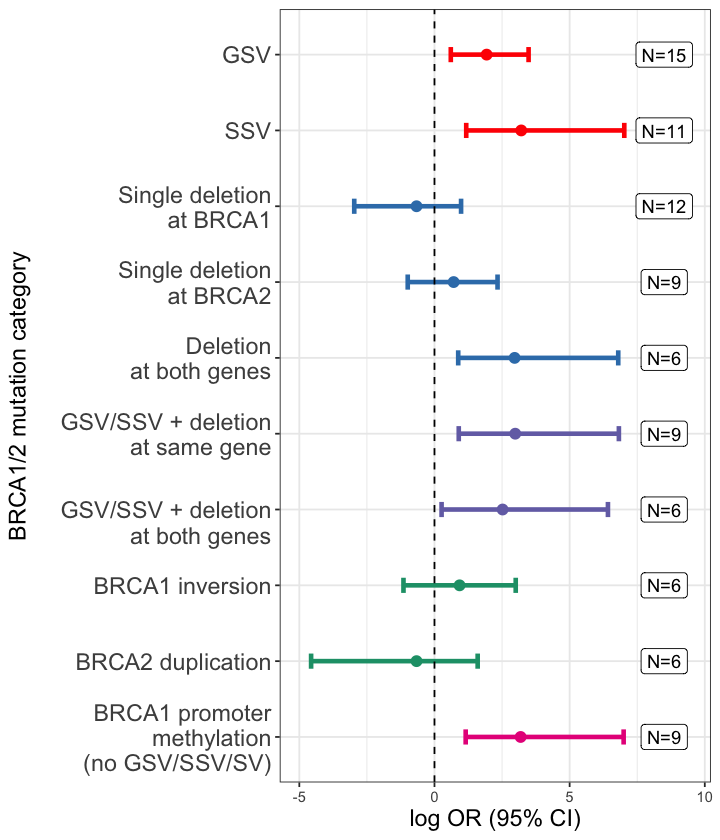

In [15]:
#Make forest plots
label <- c("GSV","SSV","Single deletion\nat BRCA1","Single deletion\nat BRCA2","\nDeletion\nat both genes\n",
           "\nGSV/SSV + deletion\nat same gene\n","\nGSV/SSV + deletion\nat both genes",
           "BRCA1 inversion","BRCA2 duplication","BRCA1 promoter\nmethylation\n (no GSV/SSV/SV)")
n<-HRDrisk_enrichment[,1]
mean  <- HRDrisk_enrichment[,2]
lower <- HRDrisk_enrichment[,3]
upper <- HRDrisk_enrichment[,4]
col<-c("SNV","SNV","Deletion","Deletion","Deletion","SNV + deletion","SNV + deletion","Non-deletion SV",
       "Non-deletion SV","Methylation")

df <- data.frame(n,label, mean=log(mean), lower=log(lower), upper=log(upper),col=col)
myColors <- c("red","#377EB8",brewer.pal(6,"Dark2")[1],brewer.pal(6,"Dark2")[3],brewer.pal(6,"Dark2")[4])


types<-c("SNV","Deletion","Non-deletion SV","SNV + deletion","Methylation")
names(myColors) <- types
myColors

colScale <- scale_colour_manual(name = "BRCA status",values = myColors,breaks=types)



df$label <- factor(df$label, levels=rev(df$label))

options(repr.plot.width=5,repr.plot.height=5)
fp <- ggplot(data=df, aes(x=label, y=mean, ymin=lower, ymax=upper,colour=col)) +
        geom_pointrange() + geom_errorbar(width=0.2,cex=1.3)+
        geom_hline(yintercept=0, lty=2) +  
        coord_flip() +  
        xlab("BRCA1/2 mutation category\n")+ ylab("log OR (95% CI)") +
        annotate("label",y=8.5,x=label,label=paste("N=",df$n,sep=""))+
        theme_bw()  +
        theme(axis.text.y=element_text(size=14),axis.title=element_text(size=14),
                           legend.text=element_text(size=12),legend.title=element_text(size=12,face="bold"),
              legend.position="None")+
ylim(-5,9.5)+
                           
        colScale 

options(repr.plot.width=6,repr.plot.height=7)
#png("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/Figures/Intermediate_figure_making_files/Figure3/Forestplot_BRCAstatus_HRD_v3.png",width=8,height=7,unit="in",res=300)
fp
#dev.off()

## Make second panel box plots


In [16]:
#Make mutexclcategory
hrd_snv_only<-dat[(dat$BRCAstatus=="Germline SNV"|dat$BRCAstatus=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "HRDetect"]
df_1<-data.frame(MutCat="SNV_only",HRD=hrd_snv_only,Col="SNV")

hrd_germSNV<-dat[(dat$BRCAstatus=="Germline SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "HRDetect"]
df_2<-data.frame(MutCat="Germline SNV only",HRD=hrd_germSNV,Col="SNV")

hrd_somSNV<-dat[(dat$BRCAstatus=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "HRDetect"]
df_3<-data.frame(MutCat="Somatic SNV only",HRD=hrd_somSNV,Col="SNV")

hrd_anydel<-dat[dat$BRCAstatus=="Deletion overlapping exon (LOF)"  ,
    "HRDetect"]
df_4<-data.frame(MutCat="Any deletion only",HRD=hrd_anydel,Col="Deletion")

hrd_singledel_brca1<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" &
                    dat$BRCA1status=="Deletion overlapping exon (LOF)"),
                   "HRDetect"]
df_5<-data.frame(MutCat="Single deletion at BRCA1",HRD=hrd_singledel_brca1,Col="Deletion")

hrd_singledel_brca2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" &
                    dat$BRCA2status=="Deletion overlapping exon (LOF)"),
                   "HRDetect"]
df_ex<-data.frame(MutCat="Single deletion at BRCA2",HRD=hrd_singledel_brca2,Col="Deletion")

hrd_doubledel<-dat[(dat$BRCAstatus_SV=="Double deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)"),"HRDetect"]
df_6<-data.frame(MutCat="Double deletion",HRD=hrd_doubledel,Col="Deletion")

hrd_sameorboth<-dat[((dat$BRCAstatus_compound=="SNV + deletion (same gene)")|
                     (dat$BRCAstatus_compound=="SNV + deletions (both genes)"))
  , "HRDetect"]
df_7<-data.frame(MutCat="Compound same or both",HRD=hrd_sameorboth,Col="SNV + deletion")

hrd_same<-dat[((dat$BRCAstatus_compound=="SNV + deletion (same gene)"))
  , "HRDetect"]
df_8<-data.frame(MutCat="Compound same",HRD=hrd_same,Col="SNV + deletion")

hrd_both<-dat[((dat$BRCAstatus_compound=="SNV + deletions (both genes)"))
  , "HRDetect"]
df_9<-data.frame(MutCat="Compound both",HRD=hrd_both,Col="SNV + deletion")


hrd_brca1inv<-dat[(dat$BRCA1status=="Inversion spanning gene (INV_SPAN)" & dat$BRCA2status=="None") ,
    "HRDetect"]
df_11<-data.frame(MutCat="BRCA1 inversion",HRD=hrd_brca1inv,Col="Non-deletion SV")

hrd_brca2dups<-dat[(dat$BRCA2status=="Duplication spanning gene (COPY_GAIN)" & dat$BRCA1status=="None") ,
    "HRDetect"]
df_12<-data.frame(MutCat="BRCA2 duplication",HRD=hrd_brca2dups,Col="Non-deletion SV")



hrd_methyl<-sampleInfo[sampleInfo$BRCAstatus == "BRCA1 promoter methylation","HRDetect"]
df_13<-data.frame(MutCat="Promoter methylation",HRD=hrd_methyl,Col="Methylation")

hrd_df<-rbind(df_2,df_3,df_5,df_ex,df_6,df_8,df_9,df_11,df_12,df_13)


table(hrd_df$MutCat)



       Germline SNV only         Somatic SNV only Single deletion at BRCA1 
                      15                       11                       12 
Single deletion at BRCA2          Double deletion            Compound same 
                       9                        6                        9 
           Compound both          BRCA1 inversion        BRCA2 duplication 
                       6                        6                        6 
    Promoter methylation 
                       9 

In [17]:
levels(hrd_df$MutCat)
hrd_df$MutCat <- factor(hrd_df$MutCat, levels=rev(levels(hrd_df$MutCat)))
myColors <- c("red","#377EB8",brewer.pal(6,"Dark2")[3],brewer.pal(6,"Dark2")[1],brewer.pal(6,"Dark2")[4])
types<-c("SNV","Deletion","SNV + deletion","Non-deletion SV","Methylation")
labels <- c("Germline SNV","Somatic SNV", "Single deletion\nat BRCA1","Single deletion\nat BRCA2","\nDeletion\nat both genes\n",
           "\nSNV + deletion\nat same gene\n","\nSNV + deletion\nat both genes",
           "Non-deletion SV","BRCA1 inversion", "BRCA2 duplication","BRCA1 promoter\nmethylation\n (no SNV/SV)")

boxplot_panel<-ggplot(hrd_df,aes(x=MutCat,y=HRD,colour=Col))+
geom_boxplot(outlier.shape=NA)+
geom_jitter(width=0.1)+

coord_flip()+theme_bw()+scale_x_discrete(labels=rev(labels))+
scale_colour_manual(values=myColors,breaks=types)+
theme(axis.title.x=element_text(size=14),axis.text.y=element_blank(),legend.position="None")+
xlab("")+ylab("HRDetect score")


[1] "Germline SNV only"        "Somatic SNV only"        
 [3] "Single deletion at BRCA1" "Single deletion at BRCA2"
 [5] "Double deletion"          "Compound same"           
 [7] "Compound both"            "BRCA1 inversion"         
 [9] "BRCA2 duplication"        "Promoter methylation"

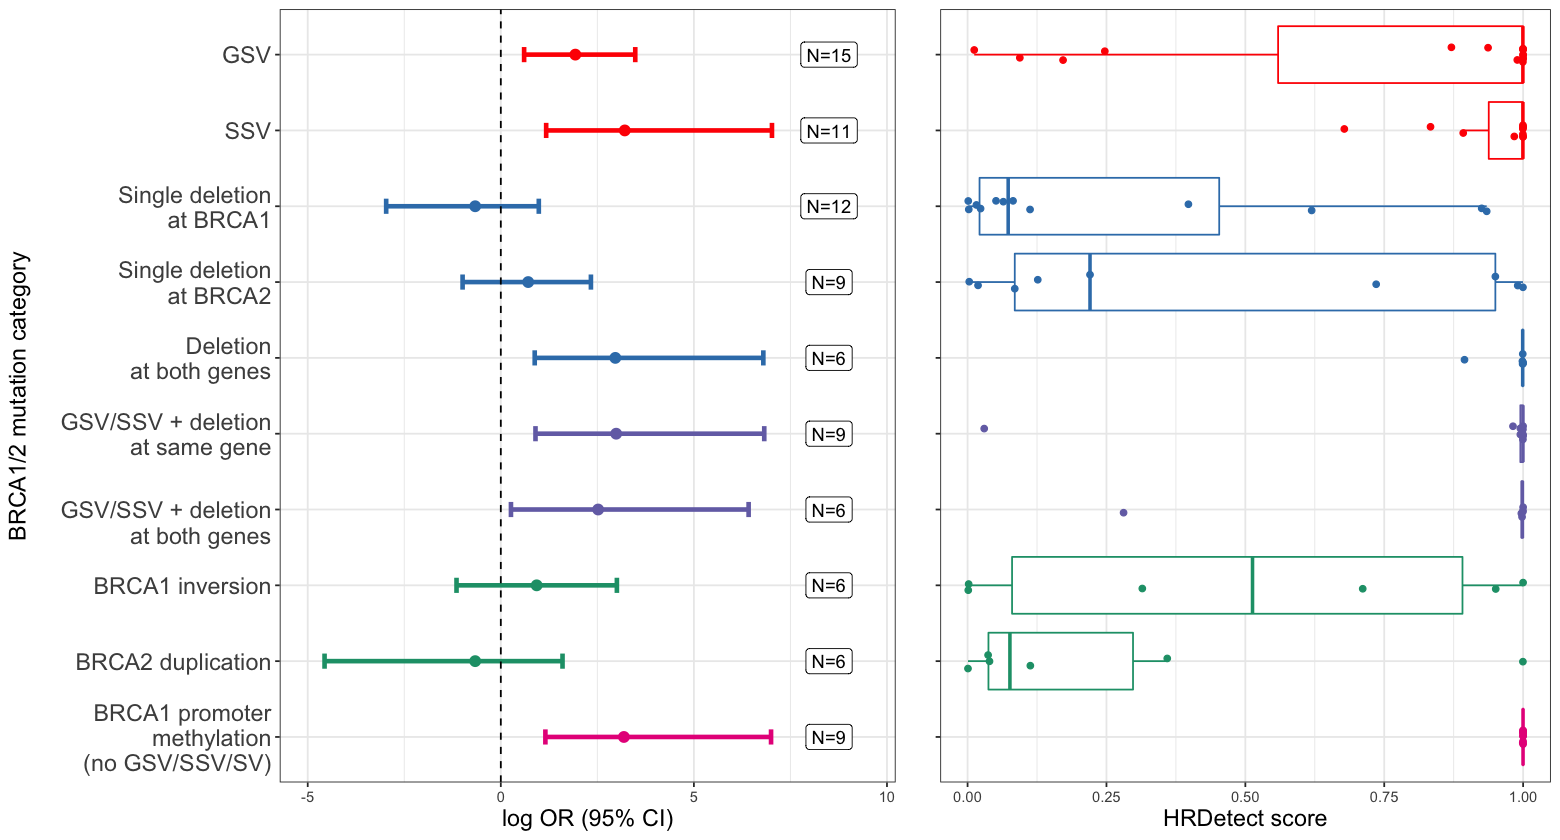

In [21]:
library(gridExtra)
options(repr.plot.width=13)
library(cowplot)
#png("~/Desktop/BRCA1_BRCA2_SVs_paper/Manuscript/Intermediate_figures/Fig3_forestplots_withbox2.png",
   #width=13,height=6,res=300,unit="in")
#png("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/Manuscript/Intermediate_figures/Fig3_forestplots_withbox.png",
   #width=13,height=6,res=300,unit="in")
    plot_grid(fp, boxplot_panel, align = "h", nrow = 1,rel_widths = c(0.58,0.42))
#dev.off()

**BRCA1**

In [101]:
sampleInfo$Cohort<-substr(sampleInfo$Sample,1,2)

dat<-sampleInfo[sampleInfo$BRCA1_pro_meth!=1,]

In [102]:
dat$HRDeficient<-ifelse(dat$HRDetect>0.7,1,0)
dat$BRCA1status<-as.factor(dat$BRCA1status)
dat$BRCA1status <- relevel(dat$BRCA1status, ref = "None")

dat$BRCA1status_grpsvs<-as.character(dat$BRCA1status)
dat$BRCA1status_grpsvs_av<-as.character(dat$BRCA1status)

dat[(dat$BRCA1status=="Germline SNV"|dat$BRCA1status=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCA1status_grpsvs_av"]<-"SNV only"

dat[(dat$BRCA1status=="Germline SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCA1status_grpsvs"]<-"Germline SNV only"

dat[(dat$BRCA1status=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCA1status_grpsvs"]<-"Somatic SNV only"

dat[(dat$BRCA1status!="Germline SNV" & dat$BRCA1status!="Somatic SNV" & dat$BRCA1status!="None" &
     dat$BRCA1status!="Deletion overlapping exon (LOF)" & 
     dat$BRCA1status!="Complex combination of SV intervals including 1+ LOF (CPX: LOF)") & 
    dat$BRCA2status!="Germline SNV" & dat$BRCA2status!="Somatic SNV" & dat$BRCA2status!="Deletion overlapping exon (LOF)",
    "BRCA1status_grpsvs"]<-"Non-deletion structural variant"


dat[(dat$BRCA1status=="Inversion spanning gene (INV_SPAN)") & dat$BRCA2status=='None'  ,
   "BRCA1status_grpsvs"]<-"BRCA1 inversion"


table(dat$BRCA1status)

dat[dat$BRCA1status=="Deletion overlapping exon (LOF)" ,"BRCA1status_grpsvs"]<-"Deletion"





                                                           None 
                                                            119 
Complex combination of SV intervals including 1+ LOF (CPX: LOF) 
                                                              2 
                         Complex combination of SVs without LOF 
                                                              3 
                                Deletion overlapping exon (LOF) 
                                                             24 
                                                   Germline SNV 
                                                             21 
                             Inversion spanning gene (INV_SPAN) 
                                                              9 
                                                    Somatic SNV 
                                                             10 

In [103]:
HRDrisk_enrichment<-data.frame()

#Test BRCA1status with at least 5 events

#print("SNV no SVs")
dat2<-dat[dat$BRCA1status_grpsvs_av %in% c("SNV only","None"),]
    dat2$BRCA1status_grpsvs_av<-factor(dat2$BRCA1status_grpsvs_av,levels=c("None","SNV only"))
table(dat2$BRCA1status_grpsvs_av)
  snvnondel<-exact2x2(dat2$BRCA1status_grpsvs_av,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCA1status_grpsvs_av)[2],snvnondel$estimate,snvnondel$conf.int,snvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Germline SNV only")
dat2<-dat[dat$BRCA1status_grpsvs %in% c("Germline SNV only","None"),]
    dat2$BRCA1status_grpsvs<-factor(dat2$BRCA1status_grpsvs,levels=c("None","Germline SNV only"))
table(dat2$BRCA1status_grpsvs,dat2$HRDeficient)
  gsnvnondel<-exact2x2(dat2$BRCA1status_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCA1status_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    #HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

  f_pseudo<-exact2x2(matrix(c(80,42,1,10),byrow=TRUE,nrow=2),tsmethod="central")
    adj_pvalue<-p.adjust(f_pseudo$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCA1status_grpsvs)[2],f_pseudo$estimate,f_pseudo$conf.int,f_pseudo$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("Somatic SNV only:")
dat2<-dat[dat$BRCA1status_grpsvs %in% c("Somatic SNV only","None"),]
    dat2$BRCA1status_grpsvs<-factor(dat2$BRCA1status_grpsvs,levels=c("None","Somatic SNV only"))
table(dat2$BRCA1status_grpsvs)
  gsnvnondel<-exact2x2(dat2$BRCA1status_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCA1status_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("Single deletion (noSNV):")
    dat2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCA1status=="Deletion overlapping exon (LOF)"),]
    dat2$grp<-"Single del"

    print("Dimensions of single deletions:")
    dim(dat2)

    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Single del"))
   singledel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(singledel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],singledel$estimate,singledel$conf.int,singledel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("SNV+deletion (same gene):")
    dat2<-dat[(dat$BRCA1status_compound=="SNV + deletion (same gene)" ),]

    print("Dimensions of SNV+deletion (same gene):")
    dim(dat2)

    dat2$grp<-"snv+del_same"
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","snv+del_same"))
    snv_del<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snv_del$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],snv_del$estimate,snv_del$conf.int,snv_del$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("Non-deletion SV at least one gene in absense of SNVs or deletions:")
    dat2<-dat[(dat$BRCA1status_grpsvs=="Non-deletion structural variant" ),]
    dat2$grp<-"nondelSV"

    print("Dimensions of non-deletion SV:")
    dim(dat2)
    
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","nondelSV"))
   nondel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    #HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("Non-deletion SV at least one gene in absense of SNVs or deletions:")
    dat2<-dat[(dat$BRCA1status_grpsvs=="BRCA1 inversion" ),]
    dat2$grp<-"BRCA1inversion"

    print("Dimensions of BRCA1 inversion:")
    dim(dat2)
    
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","BRCA1inversion"))
   nondel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)



    None SNV only 
     119       17 

                   
                     0  1
  None              79 40
  Germline SNV only  0  9


            None Somatic SNV only 
             119                8 

[1] "Dimensions of single deletions:"


[1] 13 33

[1] "Dimensions of SNV+deletion (same gene):"


[1]  6 32

[1] "Dimensions of non-deletion SV:"


[1]  6 33

[1] "Dimensions of BRCA1 inversion:"


[1]  6 33

In [104]:
colnames(HRDrisk_enrichment)<-c("N","OR","LCI","UCI","Pvalue","AdjPvalue")
rownames(HRDrisk_enrichment)<-c("SNVonly","GermlineSNV","SomaticSNV","SingleDeletion",
                                "SNV+deletion_same","BRCA1inversion")
HRDrisk_enrichment

,N,OR,LCI,UCI,Pvalue,AdjPvalue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SNVonly,17,30.9185528,4.4974040,1332.155303,3.717293e-06,4.832481e-05
GermlineSNV,9,18.6768292,2.5084828,833.064274,7.112640e-04,9.246432e-03
SomaticSNV,8,13.5600251,1.6514306,628.642912,7.976711e-03,1.036972e-01
SingleDeletion,13,0.7698778,0.1258689,3.332957,9.948802e-01,1.000000e+00
SNV+deletion_same,6,12.4324614,1.3005590,612.388813,2.268226e-02,2.948694e-01
BRCA1inversion,6,2.5313649,0.3175972,20.199359,4.813408e-01,1.000000e+00


Warning message:
“Removed 4 rows containing missing values (geom_pointrange).”Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”

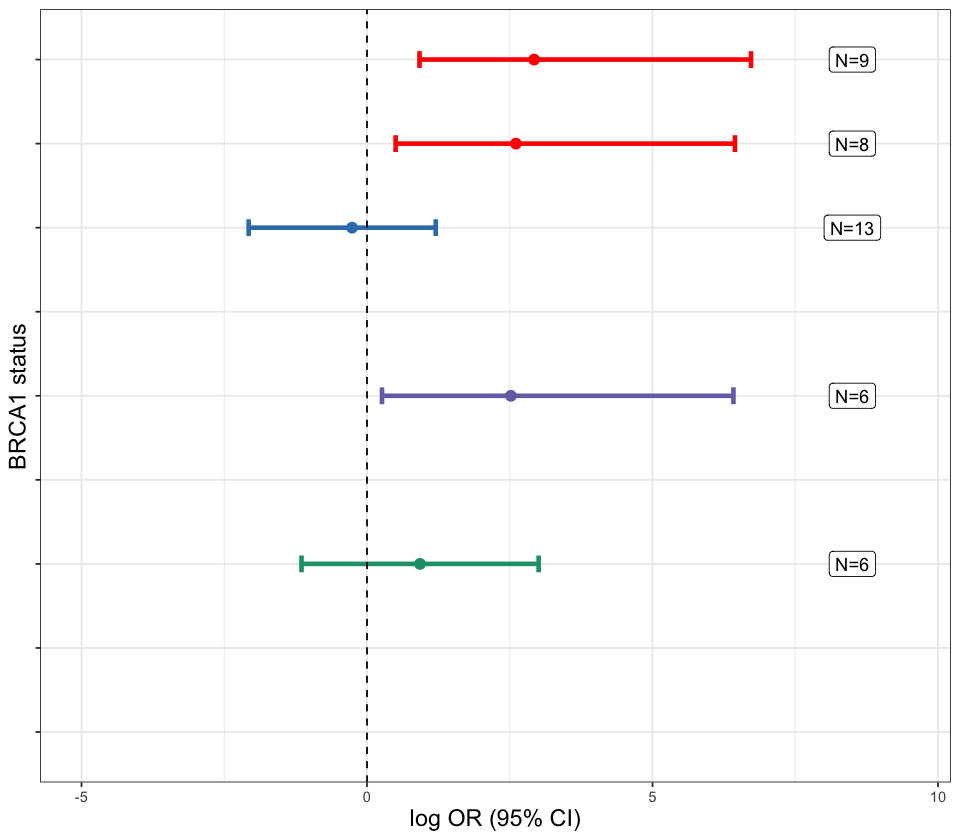

In [105]:
#Make forest plots,""
label <- c("GSV","SSV","Single deletion",".",
           "SNV + deletion\nat same gene\n","`","BRCA1 inversion","~",",")
n  <- c(HRDrisk_enrichment[2:3,1],HRDrisk_enrichment[4,1],NA,HRDrisk_enrichment[5,1],NA,HRDrisk_enrichment[6,1],NA,NA)
mean  <- c(HRDrisk_enrichment[2:3,2],HRDrisk_enrichment[4,2],NA,HRDrisk_enrichment[5,2],NA,HRDrisk_enrichment[6,2],NA,NA)
lower <- c(HRDrisk_enrichment[2:3,3],HRDrisk_enrichment[4,3],NA,HRDrisk_enrichment[5,3],NA,HRDrisk_enrichment[6,3],NA,NA)
upper <- c(HRDrisk_enrichment[2:3,4],HRDrisk_enrichment[4,4],NA,HRDrisk_enrichment[5,4],NA,HRDrisk_enrichment[6,4],NA,NA)

col<-c("SNV","SNV","Deletion","","SNV + deletion","","Non-deletion SV","","")

df <- data.frame(n,label, mean=log(mean), lower=log(lower), upper=log(upper),col=col)
myColors <- c("red","#377EB8",brewer.pal(6,"Dark2")[1],brewer.pal(6,"Dark2")[3],NA)

types<-c("SNV","Deletion","Non-deletion SV","SNV + deletion","")
names(myColors) <- types

colScale <- scale_colour_manual(name = "BRCA1 status",values = myColors,breaks=types)

df$label <- factor(df$label, levels=rev(df$label))

options(repr.plot.width=8)
fp1 <- ggplot(data=df, aes(x=label, y=mean, ymin=lower, ymax=upper,colour=col)) +
        geom_pointrange() + geom_errorbar(width=0.2,cex=1.3)+
        geom_hline(yintercept=0, lty=2) +  
        coord_flip() +  
        xlab("BRCA1 status") + ylab("log OR (95% CI)") +
        annotate("label",y=8.5,x=df$label[c(1:3,5,7)],label=paste("N=",df[c(1:3,5,7),"n"],sep=""))+
        theme_bw()  +theme(axis.text.y=element_blank(),axis.title=element_text(size=14),
                           legend.position="None")+ylim(-5,9.5)+
        colScale 

options(repr.plot.width=8,repr.plot.height=7)
#png("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/Figures/Intermediate_figure_making_files/Figure3/Forestplot_BRCA1status_HRD_v3.png",width=8,height=7,unit="in",res=300)
fp1
#dev.off()


**BRCA2**

In [90]:
sampleInfo$Cohort<-substr(sampleInfo$Sample,1,2)

dat<-sampleInfo[sampleInfo$BRCA1_pro_meth!=1,]

In [91]:
dat$HRDeficient<-ifelse(dat$HRDetect>0.7,1,0)
dat$BRCA2status<-as.factor(dat$BRCA2status)
dat$BRCA2status <- relevel(dat$BRCA2status, ref = "None")

dat$BRCA2status_grpsvs<-as.character(dat$BRCA2status)
dat$BRCA2status_grpsvs_av<-as.character(dat$BRCA2status)

dat[(dat$BRCA2status=="Germline SNV"|dat$BRCA2status=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCA2status_grpsvs_av"]<-"SNV only"

dat[(dat$BRCA2status=="Germline SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCA2status_grpsvs"]<-"Germline SNV only"

dat[(dat$BRCA2status=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCA2status_grpsvs"]<-"Somatic SNV only"

dat[(dat$BRCA2status!="Germline SNV" & dat$BRCA2status!="Somatic SNV" & dat$BRCA2status!="None" &
     dat$BRCA2status!="Deletion overlapping exon (LOF)" & 
     dat$BRCA2status!="Complex combination of SV intervals including 1+ LOF (CPX: LOF)") &
    dat$BRCA1status!="Germline SNV" & dat$BRCA1status!="Somatic SNV" &
    dat$BRCA1status!="Deletion overlapping exon (LOF)" ,
    "BRCA2status_grpsvs"]<-"Non-deletion structural variant"

dat[dat$BRCA2status=="Duplication spanning gene (COPY_GAIN)" & dat$BRCA1status=="None",
    "BRCA2status_grpsvs"]<-"BRCA2 duplication"

table(dat$BRCA2status)
dat[dat$BRCA2status=="Deletion overlapping exon (LOF)" ,"BRCA2status_grpsvs"]<-"Deletion"





                                                           None 
                                                            132 
Complex combination of SV intervals including 1+ LOF (CPX: LOF) 
                                                              1 
                         Complex combination of SVs without LOF 
                                                              4 
                                Deletion overlapping exon (LOF) 
                                                             19 
                          Duplication spanning gene (COPY_GAIN) 
                                                             10 
                                                   Germline SNV 
                                                             10 
                                  Intragenic exonic duplication 
                                                              1 
                             Inversion spanning gene (INV_SPAN) 
                        

In [92]:
HRDrisk_enrichment<-data.frame()

#Test BRCA2status with at least 5 events

#print("SNV no SVs")
dat2<-dat[dat$BRCA2status_grpsvs_av %in% c("SNV only","None"),]
    dat2$BRCA2status_grpsvs_av<-factor(dat2$BRCA2status_grpsvs_av,levels=c("None","SNV only"))
table(dat2$BRCA2status_grpsvs_av)
  snvnondel<-exact2x2(dat2$BRCA2status_grpsvs_av,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCA2status_grpsvs_av)[2],snvnondel$estimate,snvnondel$conf.int,snvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Germline SNV only")
dat2<-dat[dat$BRCA2status_grpsvs %in% c("Germline SNV only","None"),]
    dat2$BRCA2status_grpsvs<-factor(dat2$BRCA2status_grpsvs,levels=c("None","Germline SNV only"))
table(dat2$BRCA2status_grpsvs,dat2$HRDeficient)
  gsnvnondel<-exact2x2(dat2$BRCA2status_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCA2status_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Somatic SNV only:")
dat2<-dat[dat$BRCA2status_grpsvs %in% c("Somatic SNV only","None"),]
    dat2$BRCA2status_grpsvs<-factor(dat2$BRCA2status_grpsvs,levels=c("None","Somatic SNV only"))
table(dat2$BRCA2status_grpsvs)
  gsnvnondel<-exact2x2(dat2$BRCA2status_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCA2status_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("Single deletion (noSNV):")
dat2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCA2status=="Deletion overlapping exon (LOF)"),]
dat2$grp<-"Single del"
dim(dat2)
dat3<-dat[dat$BRCAstatus=="None" ,]
dat3$grp<-"None"
dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Single del"))
   singledel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
singledel
adj_pvalue<-p.adjust(singledel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],singledel$estimate,singledel$conf.int,singledel$p.value,adj_pvalue)
HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


#print("Non-deletion SV at least one gene in absense of SNVs or deletions:")
    dat2<-dat[(dat$BRCA2status_grpsvs=="Non-deletion structural variant" ),]
    dat2$grp<-"nondelSV"
    dim(dat2)
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","nondelSV"))
   nondel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    #HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#print("Non-deletion SV at least one gene in absense of SNVs or deletions:")
    dat2<-dat[(dat$BRCA2status_grpsvs=="BRCA2 duplication" ),]
    dat2$grp<-"BRCA2duplication"
    dim(dat2)
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","BRCA2duplication"))
   nondel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)







    None SNV only 
     132        9 

                   
                     0  1
  None              80 52
  Germline SNV only  4  2


            None Somatic SNV only 
             132                3 

[1] 12 33


	Central Fisher's Exact Test

data:  dat4$grp and dat4$HRDeficient
p-value = 0.08146
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.8729938 15.5290244
sample estimates:
odds ratio 
  3.532508 


[1]  5 33

[1]  6 33

In [93]:
colnames(HRDrisk_enrichment)<-c("N","OR","LCI","UCI","Pvalue","AdjPvalue")
rownames(HRDrisk_enrichment)<-c("SNVnodeletion","GermlineSNV","SomaticSNV","SingleDeletion","BRCA2duplication")
HRDrisk_enrichment

,N,OR,LCI,UCI,Pvalue,AdjPvalue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SNVnodeletion,9,1.9139296,0.39191293,10.113723,0.53899561,1
GermlineSNV,6,0.7706513,0.06741178,5.599269,1.00000000,1
SomaticSNV,3,Inf,0.61017651,Inf,0.13084951,1
SingleDeletion,12,3.5325077,0.87299378,15.529024,0.08145686,1
BRCA2duplication,6,0.5151130,0.01041891,4.943022,0.94828010,1


Warning message:
“Removed 6 rows containing missing values (geom_pointrange).”Warning message:
“Removed 6 rows containing missing values (geom_errorbar).”

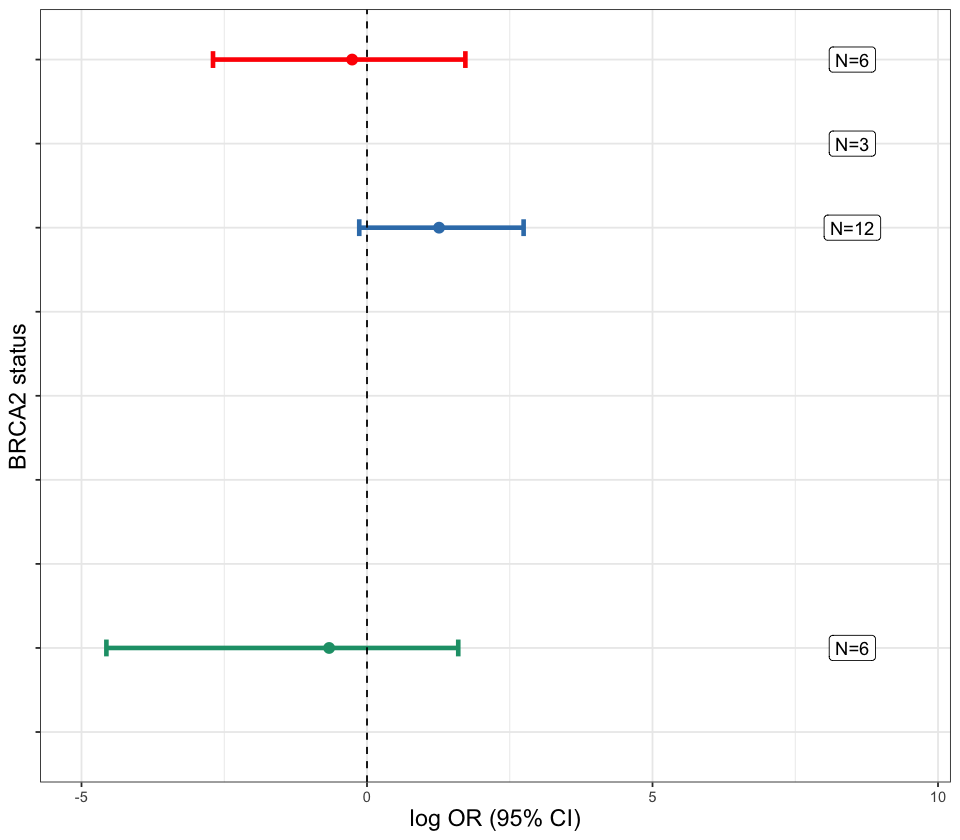

In [100]:
#Make forest plots
label <- c("Germline SNV","Somatic SNV","Single deletion","","'","`","~","BRCA2 duplication",",")
n  <- c(HRDrisk_enrichment[2:3,1],HRDrisk_enrichment[4,1],NA,NA,NA,NA,HRDrisk_enrichment[5,1],NA)
mean  <- c(HRDrisk_enrichment[2,2],NA,HRDrisk_enrichment[4,2],NA,NA,NA,NA,HRDrisk_enrichment[5,2],NA)
lower <- c(HRDrisk_enrichment[2,3],NA,HRDrisk_enrichment[4,3],NA,NA,NA,NA,HRDrisk_enrichment[5,3],NA)
upper <- c(HRDrisk_enrichment[2,4],NA,HRDrisk_enrichment[4,4],NA,NA,NA,NA,HRDrisk_enrichment[5,4],NA)




col<-c("SNV","SNV","Deletion","","","","","Non-deletion SV","")

df <- data.frame(n,label, mean=log(mean), lower=log(lower), upper=log(upper),col=col)
myColors <- c("red","#377EB8",brewer.pal(6,"Dark2")[1],NA)

types<-c("SNV","Deletion","Non-deletion SV","")
names(myColors) <- types

colScale <- scale_colour_manual(name = "BRCA2 status",values = myColors,breaks=types)

df$label <- factor(df$label, levels=rev(df$label))

options(repr.plot.width=8)
fp2 <- ggplot(data=df, aes(x=label, y=mean, ymin=lower, ymax=upper,colour=col)) +
        geom_pointrange() + geom_errorbar(width=0.2,cex=1.3)+
        geom_hline(yintercept=0, lty=2) +  
        coord_flip() +
        annotate("label",y=8.5,x=df$label[c(1:3,8)],label=paste("N=",df[c(1:3,8),"n"],sep=""))+
        xlab("BRCA2 status") + ylab("log OR (95% CI)") +
       theme_bw()  +theme(axis.text.y=element_blank(),axis.title=element_text(size=14),
                       legend.position="None")+ylim(-5,9.5)+
        colScale 

options(repr.plot.width=8,repr.plot.height=7)
#png("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/Figures/Intermediate_figure_making_files/Figure3/Forestplot_BRCA1status_HRD_v3.png",width=8,height=7,unit="in",res=300)
fp2
#dev.off()




Warning message:
“Removed 4 rows containing missing values (geom_pointrange).”Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”Warning message:
“Removed 6 rows containing missing values (geom_pointrange).”Warning message:
“Removed 6 rows containing missing values (geom_errorbar).”

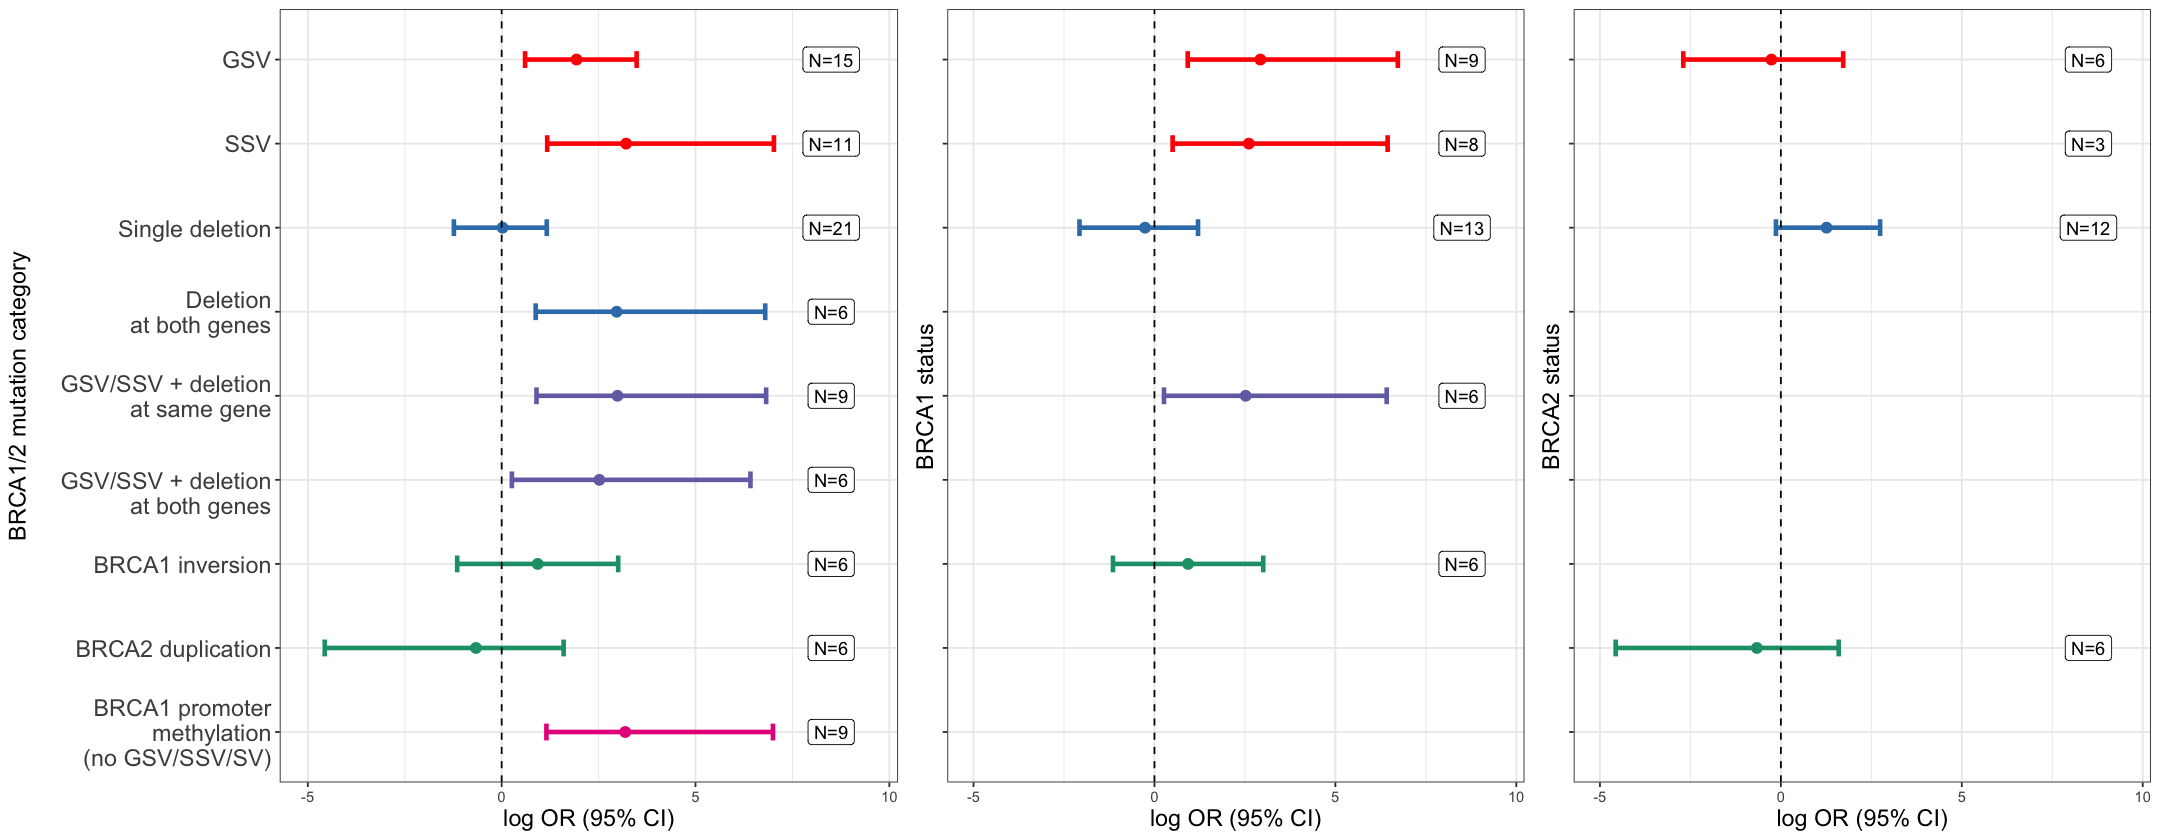

In [109]:
library(gridExtra)
options(repr.plot.width=18)
library(cowplot)
#png("~/Desktop/BRCA1_BRCA2_SVs_paper/Manuscript/Intermediate_figures/Fig3_forestplots_splitgenes.png",
 #  width=15,height=6,res=300,unit="in")
#png("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/Manuscript/Intermediate_figures/Fig3_forestplots_splitgenes.png",
  # width=15,height=6,res=300,unit="in")
   plot_grid(fp, fp1, fp2, align = "h", nrow = 1, rel_widths = c(0.42, 0.29, 0.29))
#dev.off()

**Deletions are a frequent source of biallelic BRCA1/2 inactivation in repair deficiency**


In [63]:
#rm(list=ls())
setwd("/Volumes/igmm/HGS-OvarianCancerA-SGP-WGS/BRCA1_BRCA2_SVs_paper/")
sampleInfo<-read.table("Manuscript/Intermediate_data/SampleInformation.txt",sep="\t",header=T,stringsAsFactors=F)
rownames(sampleInfo)<-sampleInfo[,1]




In [347]:
sampleInfo[(sampleInfo$BRCAstatus=="Germline SNV" |sampleInfo$BRCAstatus=="Somatic SNV") &
           (sampleInfo$BRCAstatus_SV=="Single deletion" |sampleInfo$BRCAstatus_SV=="Double deletion"),
          c("BRCA1status","BRCA1status_SV","BRCA2status","BRCA2status_SV")]

,BRCA1status,BRCA1status_SV,BRCA2status,BRCA2status_SV
,<chr>,<chr>,<chr>,<chr>
AOCS_034,Germline SNV,Deletion overlapping exon (LOF),Deletion overlapping exon (LOF),Deletion overlapping exon (LOF)
AOCS_058,Germline SNV,Deletion overlapping exon (LOF),None,SV absent
AOCS_063,Deletion overlapping exon (LOF),Deletion overlapping exon (LOF),Somatic SNV,Deletion overlapping exon (LOF)
AOCS_088,Germline SNV,SV absent,Deletion overlapping exon (LOF),Deletion overlapping exon (LOF)
AOCS_104,Deletion overlapping exon (LOF),Deletion overlapping exon (LOF),Germline SNV,SV absent
AOCS_145,Germline SNV,Deletion overlapping exon (LOF),None,SV absent
AOCS_147,Deletion overlapping exon (LOF),Deletion overlapping exon (LOF),Somatic SNV,Deletion overlapping exon (LOF)
AOCS_153,None,SV absent,Germline SNV,Deletion overlapping exon (LOF)
DO28089,Germline SNV,SV absent,Deletion overlapping exon (LOF),Deletion overlapping exon (LOF)


In [67]:
sampleInfo$HRDeficient<-ifelse(sampleInfo$HRDetect>0.7,1,0)
table(sampleInfo$BRCAstatus,sampleInfo$HRDeficient)
table(sampleInfo$BRCAstatus_SV,sampleInfo$HRDeficient)

                                                                 
                                                                   0  1
  Complex combination of SV intervals including 1+ LOF (CPX: LOF)  2  1
  Complex combination of SVs without LOF                           3  2
  Deletion overlapping exon (LOF)                                 15 15
  Duplication spanning gene (COPY_GAIN)                            5  2
  Germline SNV                                                     4 28
  Inversion spanning gene (INV_SPAN)                               3  8
  None                                                            64 34
  Somatic SNV                                                      3 15
  SV without LOF                                                   0  1

                                                                 
                                                                   0  1
  Complex combination of SV intervals including 1+ LOF (CPX: LOF)  2  1
  Complex combination of SVs without LOF                           3  4
  Double deletion                                                  1 12
  Duplication spanning gene (COPY_GAIN)                            5  4
  Intragenic exonic duplication                                    0  1
  Inversion spanning gene (INV_SPAN)                               3  8
  Single deletion                                                 16 20
  SV absent                                                       69 55
  SV without LOF                                                   0  1

In [2]:
sampleInfo["SHGSOC007",]

,Sample,Cohort,BRCAstatus,BRCA1status,BRCA2status,BRCAstatus_SV,BRCA1status_SV,BRCA2status_SV,BRCA1status_compound,BRCA2status_compound,⋯,Facets_WGD_score,WGD,Purity,AvPloidy,Mutational_load,SV_load,CNV_load,ReSig_3,ReSig_5,HRDetect
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
SHGSOC007,SHGSOC007,SH,Germline SNV,Germline SNV,Duplication spanning gene (COPY_GAIN),Duplication spanning gene (COPY_GAIN),SV absent,Duplication spanning gene (COPY_GAIN),Excluded,Excluded,⋯,0.185,0,0.50416,1.994527,6452,334,99,52.67075,0,0.8836877


In [129]:
dim(sampleInfo[sampleInfo$BRCAstatus_SV=="Single deletion" | sampleInfo$BRCAstatus_SV=="Double deletion" ,])
dim(sampleInfo[(sampleInfo$BRCAstatus_SV=="Single deletion" | sampleInfo$BRCAstatus_SV=="Double deletion") &
           (sampleInfo$BRCAstatus!="Germline SNV" & sampleInfo$BRCAstatus!="Somatic SNV"),])
dim(sampleInfo[sampleInfo$BRCAstatus=="Deletion overlapping exon (LOF)" ,])

[1] 49 30

[1] 30 30

[1] 30 30